**Last Done:** CNN functional (design choices still must be made) \\
**IPR:** fully connected model defn, combination of both models, training   

# Preliminary

In [1]:
!pip install torchinfo
!pip install --q huggingface_hub
!pip install --q transformers -U
!pip install --q sentencepiece

     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 4.0 MB 12.7 MB/s 
     |████████████████████████████████| 596 kB 48.0 MB/s 
     |████████████████████████████████| 895 kB 53.4 MB/s 
     |████████████████████████████████| 6.5 MB 36.9 MB/s 
     |████████████████████████████████| 1.2 MB 14.2 MB/s 


In [2]:
import numpy as np                  # just in case
import pandas as pd                 # for extracting info

import zipfile                      # for extracting photos from zip
from PIL import Image
from io import StringIO

import torch                        
import torch.nn as nn               
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from torchinfo import summary 
import torchvision
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import matplotlib.pyplot as plt

from tqdm import tqdm

## Parameters

In [3]:
# global variables 
img_size = 256              # assuming square images -> subject to change
img_channels = 3           # assuming RGB images 
num_outputs = 1             # we want a single number signifying the rating
batch_size = 64

# filepath = '/content/drive/MyDrive/EngSci Y3 Winter/YelpProject'    # this is the original filepath (vince)
filepath = '/content/drive/MyDrive/YelpProject'                             # use this for the shared account

# a small check to make sure the GPU is available:
# DISABLE IN COLAB WHEN NOT USING 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Extraction

The Yelp Database (uploaded to Drive) is extracted to a pandas dataframe for input into the proposed neural networks shown below.

## Text Ratings and Reviews

In [5]:
yelp_data = pd.read_json(f'{filepath}/foodEntriesWithReviews.json')

In [6]:
yelp_data = yelp_data.dropna().reset_index()
yelp_data = yelp_data.head(1000)

In [7]:
# taking a closer look at the text reviews:
yelp_data.iloc[0]['reviews']

[['Chinatown is flush with Chinese restaurants densely packed on every block - most of which, in my opinion at least, have adapted strongly to the American...',
  4],
 ['Wanted to find somewhere for a quick, reasonable meal when in Boston for the weekend.\nAll the hotpot places over crowded, overpriced, noisy and two hour...',
  4],
 ['Bustling joint in Chinatown, mainly Asian clientele so looked authentic, waitresses literally running from table to table. \n\nSteamed shrimp dumplings were...',
  3]]

In [8]:
reviews = []
ratings = []

for block_review in yelp_data['reviews']:
    if block_review:
        for review in block_review:
            reviews.append(review[0])
            ratings.append(review[1])

reviews = np.array(reviews)         
ratings = np.array(ratings)

print(f'sample review: {reviews[0]}')
print(f'corresponding rating: {ratings[0]}')
print(f'number of reviews/ratings: {ratings.size}')

sample review: Chinatown is flush with Chinese restaurants densely packed on every block - most of which, in my opinion at least, have adapted strongly to the American...
corresponding rating: 4
number of reviews/ratings: 3000


## Images

In [9]:
zip_obj = zipfile.ZipFile(f'{filepath}/foodPhotos.zip', mode='r')
zip_obj.namelist()[0:5]                 # small look into our namelist

['foodPhotos/',
 'foodPhotos/-5zFb3OJT40b_y1y-OYm3g.jpg',
 '__MACOSX/foodPhotos/._-5zFb3OJT40b_y1y-OYm3g.jpg',
 'foodPhotos/3HCtnuCU-fAyedmUldVNNA.jpg',
 '__MACOSX/foodPhotos/._3HCtnuCU-fAyedmUldVNNA.jpg']

Here is a sample image


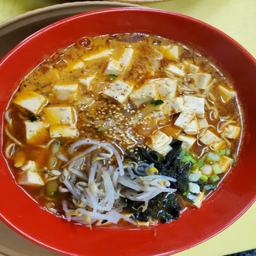

In [10]:
# a sample extraction
img_file = zip_obj.open(f'{zip_obj.namelist()[3]}')
img = Image.open(img_file)
img = img.resize((img_size, img_size))

print("Here is a sample image")
img

In [11]:
# we can convert the image to numpy array -> tensor:
img_sample_tensor = torch.tensor(np.array(img)).to(device)
img_sample_tensor = img_sample_tensor.float()
img_sample_tensor = torch.permute(img_sample_tensor, (2, 0, 1))     # make channel dimension up front
img_sample_tensor = torch.unsqueeze(img_sample_tensor, 0)
img_sample_tensor.shape

torch.Size([1, 3, 256, 256])

## Complete Image Extraction

**NOTE:** This section is completely deprecated in favour of dataloaders (do NOT run!)

In [ ]:
# # now to get all of the images
# yelp_imgs = []

# for id in yelp_data['photo_id']:
#     temp_path = f'{zip_obj.namelist()[0]}{id}.jpg'
#     img_file = zip_obj.open(temp_path)
#     img = Image.open(img_file)
#     img = img.resize((img_size, img_size))
#     yelp_imgs.append(img)

In [ ]:
# yelp_imgs = np.array(yelp_imgs)
# print(yelp_imgs)

# Data Prep

## Tokenizer and Embedding Model

In this section, we declare our embedding model which will be used to train our image-to-embedding CNN. This is done using the `HuggingFace` package, which features a pretrained BERT model.

In [12]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

text_1 = "Who was Jim Henson ?"
text_2 = "Jim Henson was a puppeteer"

# Tokenized input with special tokens around it (for BERT: [CLS] at the beginning and [SEP] at the end)
indexed_tokens = tokenizer.encode(text_1, text_2, add_special_tokens=True)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/main.zip" to /root/.cache/torch/hub/main.zip


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [13]:
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
segments_tensors = torch.tensor([segments_ids])
tokens_tensor = torch.tensor([indexed_tokens])

# get our model
bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# move our model to device
bert_model = bert_model.to(device)

In [15]:
data_extracted = np.array(yelp_data['reviews'].values)
for i in range(0, data_extracted.shape[0]):
    data_extracted[i] = np.array(data_extracted[i])

data_extracted = data_extracted.flatten()

In [16]:
# a sample tokenizer output:
test_token = tokenizer.encode(reviews[0], add_special_tokens=True)
token_tensor = torch.tensor([test_token]).to(device)

with torch.no_grad():
    test_embed = bert_model(token_tensor)[1]

print(f'Embedding vector produced with dimensionality: {test_embed.shape}')

Embedding vector produced with dimensionality: torch.Size([1, 768])


## Test/Train/Validation Splitting

In [17]:
reviews_train, reviews_test, ratings_train, ratings_test = train_test_split(reviews, ratings, test_size = 0.3)

reviews_test, reviews_valid, ratings_test, ratings_valid = train_test_split(reviews_test, ratings_test, test_size=0.33)

print(f'review train/test/valid sizes: {reviews_train.size}/{reviews_test.size}/{reviews_valid.size}')
print(f'review train/test/valid sizes: {ratings_train.size}/{ratings_test.size}/{ratings_valid.size}')

review train/test/valid sizes: 2100/603/297
review train/test/valid sizes: 2100/603/297


## Text Embedding Dataloaders

Pytorch's DataLoaders let us define large datasets that can be processed from files as inputs to our model. Data loading is GPU parallelizable, which is a necessity given the size of our dataset.

In [18]:
# now, we convert all text to embeddings as necessary:
# pytorch's dataloader class will handle parallelization for us
class embedding_data(Dataset):
    def __init__(self, tokenizer=None, model=None, reviews=None, ratings=None, device=device):
        self.tokenizer = tokenizer
        self.model = model
        self.reviews = reviews
        self.ratings = ratings

    def __len__(self):
        return self.reviews.size

    def __getitem__(self, idx):
        token = self.tokenizer.encode(self.reviews[idx], add_special_tokens=True)
        token_tensor = torch.tensor([token]).to(device)

        with torch.no_grad():
            embed = self.model(token_tensor)[1].flatten()

        rating = ratings[idx]

        return (embed, float(rating))

In [19]:
bert_data_train = embedding_data(tokenizer, bert_model, reviews_train, ratings_train)
bert_data_test = embedding_data(tokenizer, bert_model, reviews_test, ratings_test)
bert_data_valid = embedding_data(tokenizer, bert_model, reviews_valid, ratings_valid)
print(f'This is the dimensionality of a dataset entry: {bert_data_train[0][0].shape}\n')

bert_loader_train = DataLoader(bert_data_train, batch_size=batch_size)
bert_loader_test = DataLoader(bert_data_test, batch_size=batch_size)
bert_loader_valid = DataLoader(bert_data_valid, batch_size=batch_size)
sample_bert_iterator = iter(bert_loader_train)

# a sample of our embedding loader (by iterating through it)
temp = next(sample_bert_iterator)
print(f'This is the dimensionality of a dataloader batch: {temp[0].shape}')
print(temp)
print(next(sample_bert_iterator))

This is the dimensionality of a dataset entry: torch.Size([768])

This is the dimensionality of a dataloader batch: torch.Size([64, 768])
[tensor([[-0.6464,  0.4108,  0.9995,  ...,  0.9999, -0.7860,  0.9823],
        [-0.7304,  0.4473,  0.9999,  ...,  1.0000, -0.4780,  0.9874],
        [-0.7105,  0.4599,  0.9998,  ...,  0.9999, -0.8375,  0.9843],
        ...,
        [-0.6625,  0.4002,  0.9996,  ...,  0.9999, -0.8370,  0.9822],
        [-0.7480,  0.4292,  0.9997,  ...,  0.9999, -0.7167,  0.9800],
        [-0.7045,  0.3903,  0.9995,  ...,  0.9998, -0.8191,  0.9813]],
       device='cuda:0'), tensor([4., 4., 3., 5., 4., 3., 4., 3., 1., 4., 1., 3., 4., 3., 5., 4., 4., 3.,
        3., 5., 4., 4., 1., 5., 4., 2., 2., 5., 4., 4., 5., 4., 4., 2., 5., 1.,
        2., 4., 4., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 2., 4., 5., 5., 5.,
        3., 2., 1., 5., 4., 4., 5., 4., 4., 5.], dtype=torch.float64)]
[tensor([[-0.6955,  0.3864,  0.9996,  ...,  0.9999, -0.8879,  0.9891],
        [-0.6732,  0

In [20]:
# note that at any time we can go back to the start be redeclaring the iterator
sample_bert_iterator = iter(bert_loader_train)
print(next(sample_bert_iterator))

[tensor([[-0.6464,  0.4108,  0.9995,  ...,  0.9999, -0.7860,  0.9823],
        [-0.7304,  0.4473,  0.9999,  ...,  1.0000, -0.4780,  0.9874],
        [-0.7105,  0.4599,  0.9998,  ...,  0.9999, -0.8375,  0.9843],
        ...,
        [-0.6625,  0.4002,  0.9996,  ...,  0.9999, -0.8370,  0.9822],
        [-0.7480,  0.4292,  0.9997,  ...,  0.9999, -0.7167,  0.9800],
        [-0.7045,  0.3903,  0.9995,  ...,  0.9998, -0.8191,  0.9813]],
       device='cuda:0'), tensor([4., 4., 3., 5., 4., 3., 4., 3., 1., 4., 1., 3., 4., 3., 5., 4., 4., 3.,
        3., 5., 4., 4., 1., 5., 4., 2., 2., 5., 4., 4., 5., 4., 4., 2., 5., 1.,
        2., 4., 4., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 2., 4., 5., 5., 5.,
        3., 2., 1., 5., 4., 4., 5., 4., 4., 5.], dtype=torch.float64)]


# Image Data Prep

## Test/Train/Validation Splitting

In [21]:
df_train, df_test = train_test_split(yelp_data, test_size = 0.3)
df_test, df_valid = train_test_split(df_test, test_size=0.33)

df_test = df_test.reset_index()
df_valid = df_valid.reset_index()

df_train = df_train.reset_index()

print(f'review train/test/valid sizes: {len(df_train)}/{len(df_test)}/{len(df_valid)}')

review train/test/valid sizes: 700/201/99


In [22]:
df_valid.head()

,level_0,index,photo_id,business_id,caption,label,rating,reviews
0,73,73,8uKnFH-XhqUodJmUz-qDHw,tBeUzJ5RxNbArmXgQOU3MQ,Chicken Kabob,food,5.0,[[Somar Restaurant serves up some of THE BEST ...
1,304,305,sLmQyZIpIICvWuIU_IXFew,Rba9Ol4jnTiov6_iAuoF5g,,food,4.5,[[The wait was a long time and everyone was so...
2,940,945,cM9C2EwfQzcYxAJyiqVjCQ,Wu3r5hA0h3WAkiscTkaxEw,,food,4.0,[[GREAT happy hour!\n\nHubby and I shared two ...
3,925,930,2SqmEdm25qA1i0D6zn49tg,ce8ww7funWlXcHBMvAaPvg,Drunken Noodles,food,3.5,"[[I love this place. I order every other week,..."
4,380,382,nhSsJ9ABrlt11G_1-RrqDw,mmmNz7ErqPPu1QIhbZp3mw,Churros,food,3.5,[[Date night! Heard a lot about Ole Mexican Gr...


In [23]:
type(df_valid['reviews'].values[2])

list

## Image Training Dataloaders

In [24]:
# pytorch's dataloader class will handle parallelization for us
class img_data(Dataset):
    def __init__(self, df=None, zip_obj=None, tokenizer=None, model=None, img_size=img_size, device=device):
        self.df = df
        self.zip_obj = zip_obj
        self.device=device
        self.img_size = img_size
        self.tokenizer = tokenizer
        self.model = model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get image
        img_id = self.df['photo_id'][idx]
        temp_path = f'{self.zip_obj.namelist()[0]}{img_id}.jpg'
        img_file = self.zip_obj.open(temp_path)
        img = Image.open(img_file)
        img = img.resize((self.img_size, self.img_size))

        img_sample_tensor = torch.tensor(np.array(img)).to(self.device)
        img_sample_tensor = img_sample_tensor.float()
        img_sample_tensor = torch.permute(img_sample_tensor, (2, 0, 1))     # make channel dimension up front

        # get ratings
        review_block = self.df['reviews'].values[idx]
        
        # combine all reviews to get an overall rating
        review = ''
        for entry in review_block:
            review += entry[0]
            review += ' '

        token = self.tokenizer.encode(review, add_special_tokens=True)
        token_tensor = torch.tensor([token]).to(device)

        with torch.no_grad():
            embed = self.model(token_tensor)[1].flatten()

        img.close()

        return (img_sample_tensor, embed)

In [25]:
# here are our datasets
img_dataset_train = img_data(df_train, zip_obj, tokenizer, bert_model)
img_dataset_test = img_data(df_test, zip_obj, tokenizer, bert_model)
img_dataset_valid = img_data(df_valid, zip_obj, tokenizer, bert_model)

# we can index right into the directly as follows
sample_img, sample_embed = img_dataset_train[2]
print(sample_img.shape)
print(sample_embed.shape)

torch.Size([3, 256, 256])
torch.Size([768])


In [26]:
img_loader_train = DataLoader(img_dataset_train, batch_size=batch_size)
img_loader_test = DataLoader(img_dataset_test, batch_size=batch_size)
img_loader_valid = DataLoader(img_dataset_valid, batch_size=batch_size)

temp = next(iter(img_loader_train))
print(temp[0].shape)
print(temp[1].shape)

torch.Size([64, 3, 256, 256])
torch.Size([64, 768])


# Architectures

## Master Parameters

In [27]:
# set parameters here:
conv1_kernel_size = 11
conv2_kernel_size = 5
conv1_features = 20
conv2_features = 30
stride1 = 4
stride2 = 2
pool_kernel_size = 5
embedding_size = 768
hidden_ff_size = 50

## Image-to-Sentiment CNN

In [28]:
# as a preliminary, we start with a basic CNN with pooling (will be subject to change)

class simple_CNN(nn.Module):
    def __init__(self, conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size):
                 
        super(simple_CNN, self).__init__()
        # some parameters:
        self.conv1_kernel_size = conv1_kernel_size   
        self.conv2_kernel_size = conv2_kernel_size
        self.conv1_features = conv1_features
        self.conv2_features = conv2_features
        self.stride1 = stride1
        self.stride2 = stride2
        self.pool_kernel_size = pool_kernel_size
        self.embedding_size = embedding_size
        self.img_channels = 3

        # the actual layers:
        self.conv1 = nn.Conv2d(self.img_channels, self.conv1_features, self.conv1_kernel_size)
        self.pool1 = nn.MaxPool2d(pool_kernel_size)
        self.norm1 = nn.BatchNorm2d(self.conv1_features)

        self.conv2 = nn.Conv2d(self.conv1_features, self.conv2_features, self.conv2_kernel_size)
        self.pool2 = nn.MaxPool2d(self.pool_kernel_size)
        self.norm2 = nn.BatchNorm2d(self.conv2_features)

        self.fc1 = nn.Linear(2430, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, self.embedding_size)

    def _init_weights(self, module):
        '''
        initialize the layers (actual initializations are TBD)
        Linear initialization: uniform or Xavier might work here
        Conv initialization: Kaiming since we're using relu? literature says it's more effective
        '''
        if isinstance(nn.Linear):
            pass
        elif isinstance(nn.Conv2d):
            pass

    def forward(self, x):
        x = self.conv1(x).to(device)       # each conv layer consists of convolution -> activation func -> pooling
        x = self.pool1(F.relu(self.norm1(x)))

        x = self.conv2(x)
        x = self.pool2(F.relu(self.norm2(x)))

        x = x.view(-1, self.num_flat_features(x))                     # to feed into linear layers
        #x = F.sigmoid(self.fc1(x))
        #x = F.sigmoid(self.fc2(x))
        #x = torch.tanh(self.fc3(x))
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.tanh(self.fc3(x))             

        return x      

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def init_weights(self):
        return 0

In [ ]:
my_CNN = simple_CNN(conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size).to(device)
summary(my_CNN, (1, 3, img_size, img_size))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Layer (type:depth-idx)                   Output Shape              Param #
simple_CNN                               --                        --
├─Conv2d: 1-1                            [1, 20, 246, 246]         7,280
├─BatchNorm2d: 1-2                       [1, 20, 246, 246]         40
├─MaxPool2d: 1-3                         [1, 20, 49, 49]           --
├─Conv2d: 1-4                            [1, 30, 45, 45]           15,030
├─BatchNorm2d: 1-5                       [1, 30, 45, 45]           60
├─MaxPool2d: 1-6                         [1, 30, 9, 9]             --
├─Linear: 1-7                            [1, 3000]                 7,293,000
├─Linear: 1-8                            [1, 1500]                 4,501,500
├─Linear: 1-9                            [1, 768]                  1,152,768
Total params: 12,969,678
Trainable params: 12,969,678
Non-trainable params: 0
Total mult-adds (M): 483.94
Input size (MB): 0.79
Forward/backward pass size (MB): 20.38
Params size (MB): 51.88
Estima

In [ ]:
test = my_CNN(img_sample_tensor)
test

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[-4.9032e-01,  5.1122e-04,  1.0337e-01, -8.3628e-02, -1.5143e-01,
         -1.1694e-02,  2.7979e-01, -2.6219e-01,  2.8478e-01, -7.8632e-02,
          1.3490e-02, -1.9625e-01, -4.3661e-02,  1.9185e-01, -2.9818e-01,
          3.2777e-01, -3.1204e-01, -2.1656e-02, -1.8987e-01, -1.2785e-01,
          1.1033e-01, -4.6419e-01,  6.1790e-02, -2.9217e-01, -3.4527e-02,
         -1.3202e-01, -1.8992e-01, -3.3552e-01,  2.7456e-01, -1.3987e-01,
         -1.2646e-01, -4.6818e-01, -2.8148e-01,  6.1481e-01, -4.0006e-01,
         -1.3152e-01,  9.4364e-02,  2.2403e-01,  3.8157e-01,  1.5605e-01,
          3.7303e-02,  1.8392e-02,  5.6813e-01, -3.4030e-01, -2.7042e-01,
         -2.1690e-01, -4.6321e-01, -7.9836e-03, -1.9171e-01,  1.0205e-02,
          2.0355e-01,  1.6958e-01,  2.5415e-01,  7.4860e-02,  2.6385e-01,
          1.9194e-01, -2.1282e-02,  5.8334e-02,  2.0456e-01,  5.3788e-01,
          5.9048e-01, -3.9058e-02,  1.0133e-01,  2.3963e-01, -4.1275e-01,
         -3.4118e-01, -1.9080e-01,  2.

## Sentiment-to-Rating NN

In [29]:
# this will take embedding vectors -> perform regression into a single 0-5 output
class linear_NN(nn.Module):
    def __init__(self, input_size, hidden_size):
            super(linear_NN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()               # do we want this to be multiplied by 5???
    
    def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            #output = self.sigmoid(output)
            return 5.0*output

    def init_weights(self):
        torch.nn.init.kaiming_normal_(self.fc1.weight)        # since we use relu here
        torch.nn.init.xavier_normal_(self.fc2.weight)          # since we use sigmoid here

In [ ]:
# quick test:
temp_inp = torch.rand((768)).to(device)
temp_linear_model = linear_NN(768, 50).to(device)
temp_linear_model.init_weights()
temp_linear_model(temp_inp)

tensor([0.7643], device='cuda:0', grad_fn=<MulBackward0>)

## Custom Embedding CNN

This notebook defines the components of a custom CNN architecture inspired by the semantic embedding to review prediction pipeline detailed by Tang et. al. After training the sentiment CNN and declaring our feed-forward network, all that's left is to connect the CNN output -> the feed-forward network. Training will be done on the two parts separately.

In [30]:
class embed_CNN(nn.Module):
    def __init__(self, conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size, hidden_ff_size):
        super(embed_CNN, self).__init__()
        # store parameters for reference later:
        self.conv1_kernel_size = conv1_kernel_size
        self.conv2_kernel_size = conv2_kernel_size
        self.stride1 = stride1
        self.stride2 = stride2
        self.conv1_features = conv1_features
        self.conv2_features = conv2_features
        self.pool_kernel_size = pool_kernel_size
        self.embedding_size = embedding_size
        self.hidden_ff_size = hidden_ff_size

        # the two subarchitectures:
        self.CNN = simple_CNN(self.conv1_kernel_size, self.conv2_kernel_size, self.stride1, self.stride2, 
                 self.conv1_features, self.conv2_features, 
                 self.pool_kernel_size, self.embedding_size).to(device)
        self.linear = linear_NN(self.embedding_size, self.hidden_ff_size).to(device)

    def forward(self, x):
        x = self.CNN(x)
        x = self.linear(x)
        return x

    def CNN_forward(self, x):
        # for training purposes
        x  = self.CNN(x)
        return x

    def init_weights(self):
        self.CNN.init_weights()
        self.linear.init_weights()
        return 0

    def linear_forward(self, x):
        # for training purposes
        x = self.linear(x)
        return x

In [31]:
test_net = embed_CNN(conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size, hidden_ff_size).to(device)
test_net(img_sample_tensor)

tensor([[-0.0474]], device='cuda:0', grad_fn=<MulBackward0>)

In [37]:
#USE TO LOAD IN SAVED MODELS

loaded_linear = torch.load('/content/drive/MyDrive/YelpProject/Final Architectures/second_half_model')
test_net.linear.load_state_dict(loaded_linear, strict=False)

<All keys matched successfully>

In [44]:
summary(test_net, (1, 3, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
embed_CNN                                --                        --
├─simple_CNN: 1-1                        [1, 768]                  --
│    └─Conv2d: 2-1                       [1, 20, 246, 246]         7,280
│    └─MaxPool2d: 2-2                    --                        --
│    └─BatchNorm2d: 2-3                  [1, 20, 246, 246]         40
│    └─Conv2d: 2-4                       --                        (recursive)
│    └─MaxPool2d: 2-5                    [1, 20, 49, 49]           --
│    └─Conv2d: 2-6                       [1, 30, 45, 45]           15,030
│    └─BatchNorm2d: 2-7                  [1, 30, 45, 45]           60
│    └─MaxPool2d: 2-8                    [1, 30, 9, 9]             --
│    └─Linear: 2-9                       [1, 3000]                 7,293,000
│    └─Linear: 2-10                      [1, 1500]                 4,501,500
│    └─Linear: 2-11                      [1, 768]      

# Training

## Optimizer

In [ ]:
optimizer1 = torch.optim.RMSprop(test_net.linear.parameters())

In [ ]:
def trainloop(model, optimizer, iter_train, iter_results, loss_fn):
    for train_batch, result_batch in iter_train, iter_results:
        optimizer.zerograd()

        # loss
        batch_loss = loss_fn(model(train_batch), result_batch)

        # backwards call
        batch_loss.backwards()
        
        # opt step
        optimizer.step()

In [ ]:
for i, data in enumerate(bert_loader_train):
    inputs, labels = data
    labels = labels.to(device)
    print(labels)

tensor([4., 4., 3., 5., 4., 3., 4., 3., 1., 4., 1., 3., 4., 3., 5., 4., 4., 3.,
        3., 5., 4., 4., 1., 5., 4., 2., 2., 5., 4., 4., 5., 4., 4., 2., 5., 1.,
        2., 4., 4., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 2., 4., 5., 5., 5.,
        3., 2., 1., 5., 4., 4., 5., 4., 4., 5.], device='cuda:0',
       dtype=torch.float64)
tensor([5., 5., 5., 2., 3., 5., 2., 3., 5., 1., 4., 5., 1., 1., 4., 5., 2., 3.,
        1., 1., 5., 4., 5., 5., 5., 5., 5., 4., 5., 5., 4., 5., 5., 3., 4., 4.,
        2., 3., 5., 1., 3., 4., 4., 4., 5., 3., 5., 5., 4., 5., 4., 1., 5., 4.,
        4., 3., 5., 4., 1., 4., 1., 1., 5., 4.], device='cuda:0',
       dtype=torch.float64)
tensor([5., 5., 2., 4., 5., 2., 5., 4., 5., 3., 5., 5., 1., 5., 5., 5., 4., 3.,
        4., 5., 4., 2., 5., 5., 5., 5., 1., 3., 4., 5., 4., 5., 5., 5., 5., 5.,
        4., 5., 2., 1., 5., 2., 4., 5., 5., 4., 5., 5., 5., 5., 4., 4., 5., 4.,
        4., 5., 5., 4., 5., 3., 5., 5., 5., 4.], device='cuda:0',
       dtype=torch.float64

KeyboardInterrupt: ignored

## Embedding to Rating Training

In [ ]:
def train_one_epoch(epoch_index, tb_writer, optimizer, model, loss_fn):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(bert_loader_train):
        print("batch", i)
        # Every data instance is an input + label pair
        bert_batch, rating_batch = data
        bert_batch = bert_batch.to(device)
        rating_batch = rating_batch.to(device).float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(bert_batch).to(device)
        print(outputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, rating_batch)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i+1 % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(bert_loader_train) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

optimizer = torch.optim.Adam(test_net.linear.parameters(),lr = 0.01)
loss_fn = torch.nn.MSELoss()

epoch_number = 0

EPOCHS = 5

best_vloss = float('inf')

for epoch in tqdm(range(int(EPOCHS)),desc="Training Epochs"):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    test_net.linear.train(True)
    
    avg_loss = train_one_epoch(epoch_number, writer, optimizer, test_net.linear,loss_fn)

    # We don't need gradients on to do reporting
    test_net.linear.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(bert_loader_valid):
        vinputs, vlabels = vdata
        vlabels = vlabels.to(device)
        voutputs = test_net.linear(vinputs).to(device)
        vloss = loss_fn(voutputs, vlabels).to(device)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(test_net.linear.state_dict(), model_path)

    epoch_number += 1

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 1:
batch 0
tensor([[-1.5741],
        [-1.5695],
        [-1.5339],
        [-1.5066],
        [-1.4261],
        [-1.4733],
        [-1.4849],
        [-1.3534],
        [-1.5689],
        [-1.4962],
        [-1.4745],
        [-1.6307],
        [-1.5745],
        [-1.5183],
        [-1.5464],
        [-1.6054],
        [-1.5428],
        [-1.4889],
        [-1.5377],
        [-1.5183],
        [-1.4621],
        [-1.3911],
        [-1.4783],
        [-1.6473],
        [-1.4666],
        [-1.6029],
        [-1.4745],
        [-1.5291],
        [-1.5210],
        [-1.4814],
        [-1.5451],
        [-1.4912],
        [-1.5552],
        [-1.5628],
        [-1.4806],
        [-1.5213],
        [-1.4657],
        [-1.4392],
        [-1.5161],
        [-1.3833],
        [-1.5431],
        [-1.5988],
        [-1.3831],
        [-1.4991],
        [-1.5962],
        [-1.6081],
        [-1.4160],
        [-1.3627],
        [-1.4454],
        [-1.4890],
        [-1.3926],
        [-1.51

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


batch 1
tensor([[30.1101],
        [30.0833],
        [29.6140],
        [28.7612],
        [29.0935],
        [29.5683],
        [29.6388],
        [29.9988],
        [29.9690],
        [30.1998],
        [30.0687],
        [30.4621],
        [29.2016],
        [29.8199],
        [29.5269],
        [30.4331],
        [30.2056],
        [29.5550],
        [28.9802],
        [28.8725],
        [29.4711],
        [29.8437],
        [29.6125],
        [30.0498],
        [28.9581],
        [29.9266],
        [29.8448],
        [30.2001],
        [29.8250],
        [29.2142],
        [29.4519],
        [29.6648],
        [29.6127],
        [30.0319],
        [29.2828],
        [29.5368],
        [30.2033],
        [30.4264],
        [29.3854],
        [30.0952],
        [28.8881],
        [29.6386],
        [29.1020],
        [29.8771],
        [30.3900],
        [28.1880],
        [30.1988],
        [28.8493],
        [30.0010],
        [29.3804],
        [29.7671],
        [30.2481],
    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training Epochs:  20%|██        | 1/5 [00:16<01:07, 16.88s/it]

LOSS train 0.0 valid 1.7768993349690008
EPOCH 2:
batch 0
tensor([[3.4482],
        [3.4828],
        [3.4760],
        [3.4411],
        [3.5027],
        [3.4835],
        [3.5178],
        [3.5865],
        [3.4215],
        [3.4564],
        [3.4898],
        [3.4898],
        [3.4205],
        [3.4706],
        [3.4973],
        [3.4132],
        [3.4971],
        [3.4840],
        [3.3115],
        [3.5379],
        [3.4722],
        [3.5881],
        [3.4296],
        [3.4515],
        [3.5919],
        [3.5133],
        [3.4449],
        [3.4107],
        [3.5401],
        [3.5153],
        [3.4951],
        [3.4936],
        [3.3806],
        [3.3743],
        [3.4450],
        [3.5286],
        [3.4966],
        [3.5069],
        [3.4521],
        [3.4997],
        [3.4463],
        [3.4401],
        [3.5229],
        [3.4480],
        [3.4647],
        [3.4771],
        [3.6069],
        [3.4368],
        [3.3806],
        [3.4603],
        [3.5418],
        [3.5409],
       

Training Epochs:  40%|████      | 2/5 [00:33<00:50, 16.89s/it]

LOSS train 0.0 valid 1.5451329484807315
EPOCH 3:
batch 0
tensor([[4.1342],
        [4.1000],
        [4.0688],
        [4.0576],
        [4.2420],
        [4.1641],
        [4.2079],
        [4.2599],
        [4.1171],
        [4.1043],
        [4.1401],
        [4.0538],
        [4.0625],
        [4.2066],
        [4.1498],
        [4.0335],
        [4.1797],
        [4.1850],
        [4.0722],
        [4.2041],
        [4.1517],
        [4.2403],
        [4.1558],
        [4.0462],
        [4.2163],
        [4.1465],
        [4.1155],
        [4.0749],
        [4.1533],
        [4.1947],
        [4.0972],
        [4.0844],
        [4.0615],
        [4.0479],
        [4.1326],
        [4.1517],
        [4.1800],
        [4.2096],
        [4.0877],
        [4.1068],
        [4.1378],
        [4.0940],
        [4.1867],
        [4.1057],
        [4.1071],
        [4.0900],
        [4.2080],
        [4.2197],
        [4.1196],
        [4.0932],
        [4.1702],
        [4.1862],
       

Training Epochs:  60%|██████    | 3/5 [00:50<00:33, 16.89s/it]

LOSS train 0.0 valid 1.5276580182667645
EPOCH 4:
batch 0
tensor([[4.0821],
        [4.0338],
        [3.9849],
        [3.9883],
        [4.1593],
        [4.0889],
        [4.1343],
        [4.1577],
        [4.0552],
        [4.0440],
        [4.0555],
        [3.9839],
        [3.9996],
        [4.1443],
        [4.0738],
        [3.9719],
        [4.1038],
        [4.1094],
        [4.0329],
        [4.1200],
        [4.0793],
        [4.1415],
        [4.0924],
        [3.9872],
        [4.1247],
        [4.0528],
        [4.0489],
        [4.0122],
        [4.0551],
        [4.1213],
        [4.0196],
        [4.0018],
        [4.0188],
        [3.9946],
        [4.0712],
        [4.0667],
        [4.1049],
        [4.1243],
        [4.0176],
        [4.0178],
        [4.0582],
        [4.0209],
        [4.1114],
        [4.0446],
        [4.0472],
        [4.0214],
        [4.0938],
        [4.1509],
        [4.0643],
        [4.0188],
        [4.0822],
        [4.0895],
       

Training Epochs:  80%|████████  | 4/5 [01:07<00:16, 16.92s/it]

LOSS train 0.0 valid 1.53559177912738
EPOCH 5:
batch 0
tensor([[3.8906],
        [3.8442],
        [3.7839],
        [3.7957],
        [3.9277],
        [3.8760],
        [3.9211],
        [3.9195],
        [3.8523],
        [3.8533],
        [3.8407],
        [3.8031],
        [3.8079],
        [3.9323],
        [3.8670],
        [3.7866],
        [3.8899],
        [3.8922],
        [3.8387],
        [3.9021],
        [3.8698],
        [3.9118],
        [3.8822],
        [3.8102],
        [3.9085],
        [3.8318],
        [3.8467],
        [3.8154],
        [3.8350],
        [3.9112],
        [3.8219],
        [3.8020],
        [3.8382],
        [3.8048],
        [3.8711],
        [3.8575],
        [3.8924],
        [3.8971],
        [3.8203],
        [3.8082],
        [3.8375],
        [3.8167],
        [3.9027],
        [3.8507],
        [3.8584],
        [3.8299],
        [3.8605],
        [3.9222],
        [3.8584],
        [3.8177],
        [3.8690],
        [3.8638],
        [

Training Epochs: 100%|██████████| 5/5 [01:24<00:00, 16.89s/it]

LOSS train 0.0 valid 1.5740665952874389


In [ ]:
voutputs

tensor([[3.7262],
        [3.7047],
        [3.6979],
        [3.8101],
        [3.7309],
        [3.7441],
        [3.7286],
        [3.7168],
        [3.7866],
        [3.7329],
        [3.7476],
        [3.4666],
        [3.7552],
        [3.8059],
        [3.7617],
        [3.7513],
        [3.7236],
        [3.7132],
        [3.6821],
        [3.6951],
        [3.7076],
        [3.7066],
        [3.7125],
        [3.7588],
        [3.6958],
        [3.7727],
        [3.6991],
        [3.7473],
        [3.6901],
        [3.7097],
        [3.7831],
        [3.7211],
        [3.7475],
        [3.7067],
        [3.5932],
        [3.7226],
        [3.6030],
        [3.6629],
        [3.7282],
        [3.7730],
        [3.5026]], device='cuda:0', grad_fn=<MulBackward0>)

## Image to Embedding Training

In [32]:
def train_one_epoch_CNN(epoch_index, tb_writer, optimizer, model, loss_fn):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(img_loader_train):
        print("batch", i)
        # Every data instance is an input + label pair
        img_batch, bert_batch = data
        img_batch = img_batch.to(device)
        bert_batch = bert_batch.to(device).float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(img_batch).to(device)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, bert_batch)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i+1 % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(img_loader_train) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [34]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

optimizer = torch.optim.Adam(test_net.CNN.parameters(),lr = 0.01)
loss_fn = torch.nn.MSELoss()

epoch_number = 0

EPOCHS = 5

best_vloss = float('inf')

for epoch in tqdm(range(int(EPOCHS)),desc="Training Epochs"):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    test_net.CNN.train(True)
    
    avg_loss = train_one_epoch_CNN(epoch_number, writer, optimizer, test_net.CNN,loss_fn)

    # We don't need gradients on to do reporting
    test_net.CNN.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(img_loader_valid):
        vinputs, vlabels = vdata
        vlabels = vlabels.to(device)
        voutputs = test_net.CNN(vinputs).to(device)
        vloss = loss_fn(voutputs, vlabels).to(device)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(test_net.CNN.state_dict(), model_path)

    epoch_number += 1



Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 1:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10


Training Epochs:  20%|██        | 1/5 [00:24<01:36, 24.07s/it]

LOSS train 0.0 valid 0.250480055809021
EPOCH 2:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10


Training Epochs:  40%|████      | 2/5 [00:47<01:11, 23.73s/it]

LOSS train 0.0 valid 0.250480055809021
EPOCH 3:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10


Training Epochs:  60%|██████    | 3/5 [01:11<00:47, 23.64s/it]

LOSS train 0.0 valid 0.250480055809021
EPOCH 4:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10


Training Epochs:  80%|████████  | 4/5 [01:34<00:23, 23.64s/it]

LOSS train 0.0 valid 0.250480055809021
EPOCH 5:
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10


Training Epochs: 100%|██████████| 5/5 [01:58<00:00, 23.68s/it]

LOSS train 0.0 valid 0.250480055809021


In [35]:
voutputs[1].div_(torch.norm(voutputs[1],2))

tensor([-0.0361,  0.0361,  0.0361, -0.0361,  0.0361,  0.0361,  0.0361, -0.0361,
        -0.0361, -0.0361,  0.0361,  0.0361, -0.0361, -0.0361,  0.0361, -0.0361,
         0.0361, -0.0361, -0.0361, -0.0361, -0.0361, -0.0361,  0.0361,  0.0361,
         0.0361, -0.0361,  0.0361,  0.0361,  0.0361, -0.0361, -0.0361, -0.0361,
         0.0361, -0.0361,  0.0361,  0.0361,  0.0361,  0.0361,  0.0361, -0.0361,
        -0.0361, -0.0361,  0.0361, -0.0361,  0.0361,  0.0361,  0.0361, -0.0361,
        -0.0361,  0.0361, -0.0361,  0.0361, -0.0361,  0.0361,  0.0361,  0.0361,
         0.0361, -0.0361, -0.0361,  0.0361,  0.0361,  0.0361,  0.0361,  0.0361,
         0.0361, -0.0361, -0.0361,  0.0361, -0.0361,  0.0361,  0.0361,  0.0361,
         0.0361, -0.0361, -0.0361, -0.0361,  0.0361, -0.0361,  0.0361,  0.0361,
         0.0361, -0.0361,  0.0361, -0.0361, -0.0361,  0.0361, -0.0361, -0.0361,
         0.0361, -0.0361,  0.0361, -0.0361,  0.0361, -0.0361,  0.0361, -0.0361,
        -0.0361,  0.0361,  0.0361, -0.03

In [36]:
voutputs[1].div_(torch.norm(voutputs[0],2))

tensor([-0.0013,  0.0013,  0.0013, -0.0013,  0.0013,  0.0013,  0.0013, -0.0013,
        -0.0013, -0.0013,  0.0013,  0.0013, -0.0013, -0.0013,  0.0013, -0.0013,
         0.0013, -0.0013, -0.0013, -0.0013, -0.0013, -0.0013,  0.0013,  0.0013,
         0.0013, -0.0013,  0.0013,  0.0013,  0.0013, -0.0013, -0.0013, -0.0013,
         0.0013, -0.0013,  0.0013,  0.0013,  0.0013,  0.0013,  0.0013, -0.0013,
        -0.0013, -0.0013,  0.0013, -0.0013,  0.0013,  0.0013,  0.0013, -0.0013,
        -0.0013,  0.0013, -0.0013,  0.0013, -0.0013,  0.0013,  0.0013,  0.0013,
         0.0013, -0.0013, -0.0013,  0.0013,  0.0013,  0.0013,  0.0013,  0.0013,
         0.0013, -0.0013, -0.0013,  0.0013, -0.0013,  0.0013,  0.0013,  0.0013,
         0.0013, -0.0013, -0.0013, -0.0013,  0.0013, -0.0013,  0.0013,  0.0013,
         0.0013, -0.0013,  0.0013, -0.0013, -0.0013,  0.0013, -0.0013, -0.0013,
         0.0013, -0.0013,  0.0013, -0.0013,  0.0013, -0.0013,  0.0013, -0.0013,
        -0.0013,  0.0013,  0.0013, -0.00

In [ ]:
test_net.forward()